# User Based Movie Recommendation System

Since the birth of cinemas till now. There have been a lot of modifications. From the First Short Clippings, then sound, then colour and now we enjoy 3D cinemas and wonder about the next big thing.
<br>
We have so many options that we are often confused and constantly rely on friends or AI to recommend us some movies.

In this notebook I have attempted to make a Unique User Based Movie Recommendation System with a little bit of predictive modeling.

Prediction requires user input and this being a final project, I couldn't gather much data. So I found a dataset which has recorded user inputs and has a large enough dataset to perform the predictive model on.

Dataset can be found [here](https://www.kaggle.com/rounakbanik/the-movies-dataset)

Some information and warnings
<br><br>
**Author:** Rushabh Barbhaya<br>
**Guided by:** Dr. Carlo Lipizzi<br> 

<br>**Subject:** EM624
>	Informatics for Engineering Management
<br>

**Project Topic:** Movie Recommendation System<br>
Dataset: The Movies Dataset
>	link -> https://www.kaggle.com/rounakbanik/the-movies-dataset
>	<br>Dataset size -> 990mb (7 csv files / 5 used)
>	<br>	csv1:
>	<br>	Name: movies_metadata.csv
>	<br>	entries: 45466 x 24 data entries
	<br>	csv2:
	<br>	Name: credits.csv
	<br>	entries: 25476 x 3 data entries
	<br>	csv3:
	<br>	Name: keywords.csv
	<br>	entires: 46419 x 2 data entries
	<br>	csv4:
	<br>	Name: links_small.csv
	<br>	entries: 9112 entries
	<br>	csv5:
	<br>	Name: ratings.csv
	<br>	entries: 100004 x 4 entries

**Features:
	- User Based Search Recommendation
	- Provides chart toppers for the movie entered
	- Provides data story
	- Describes the movie selected**

***
**Requirements:** Microsoft Visual Studio v14+<br>
**Warnings:** Computational Heavy Code<br>
***

**Limitations:**
	Couldn't run the code on whole dataset due to lack of computational power.

Importing all the necessary libraries

In [1]:
%matplotlib inline
import time
import pandas as pd
from ast import literal_eval
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD, evaluate
import warnings
from IPython.display import Image, HTML
warnings.filterwarnings("ignore")
plotly.tools.set_credentials_file(username='rounakbanik', api_key='xTLaHBy9MVv5szF4Pwan')
sns.set_style('whitegrid')
sns.set(font_scale=1.25)
pd.set_option('display.max_colwidth', 50)

Importing all the datasets and removing the rows which are causing runtime errors

In [2]:
dataset = pd.read_csv("movies_metadata.csv")
dataset = dataset.drop([19730, 29503, 35587])
credit = pd.read_csv("credits.csv")
keywords = pd.read_csv("keywords.csv")
links = pd.read_csv("links_small.csv")
ratings = pd.read_csv("ratings_small.csv")

Cleaning and sorting the dataset

In [3]:
dataset["title"] = dataset["title"].astype("str")
dataset["overview"] = dataset["overview"].astype("str")
dataset["revenue"] = pd.to_numeric(dataset["revenue"], errors = "coerce")
dataset["revenue"] = dataset["revenue"].replace(0, np.nan)
#dataset["revenue"] = dataset["revenue"].astype("int")
dataset["budget"] = pd.to_numeric(dataset["budget"], errors = "coerce")
dataset["budget"] = dataset["budget"].replace(0, np.nan) 
dataset["return"] = dataset["revenue"] / dataset["budget"]
dataset["year"] = pd.to_datetime(dataset["release_date"], errors = "coerce").apply(lambda x: str(x).split("-")[0] if x != np.nan else np.nan) # Creating a year column to check the year of release
poster_url = "http://image.tmdb.org/t/p/w185" # Heading for movie Poster
dataset["poster_path"] = "<img src='" + poster_url + dataset["poster_path"] + "'style='height:100px;'>" # Adding Path for movie poster - Viz works best in Jupyter Notebook
links = links[links["tmdbId"].notnull()]["tmdbId"].astype("int")

From here we are exploring the dataset. <br> Checking the dataset to see if more cleaning is required

In [4]:
dataset.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,return,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,12.451801,1995
1,False,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,4.043035,1995
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",NaN,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,NaN,1995
3,False,NaN,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,5.090760,1995
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",NaN,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,NaN,1995


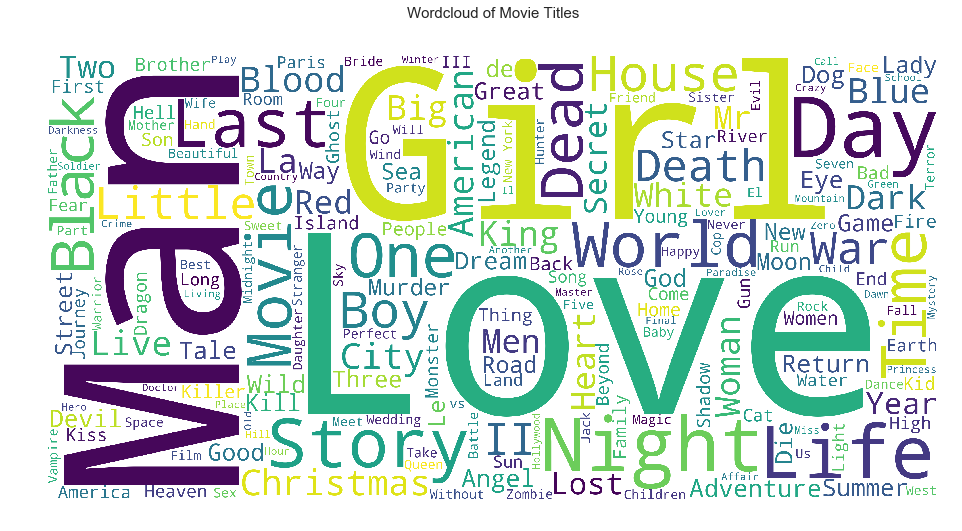

In [5]:
title_wc = " ".join(dataset["title"])
title_wordcloud = WordCloud(stopwords = STOPWORDS, background_color = "white", height = 2000, width = 4000).generate(title_wc)
plt.figure(figsize = (16,9))
plt.imshow(title_wordcloud)
plt.axis("off")
plt.title("Wordcloud of Movie Titles\n\n")
plt.show()

The words "Man", "Girl" & "Love" appears to be a lot in the movie titles. <br> More cleaning is required to understand the data

In [6]:
dataset["production_countries"] = dataset["production_countries"].fillna("[]").apply(literal_eval)
dataset["production_countries"] = dataset["production_countries"].apply(lambda x: [i["name"] for i in x] if isinstance(x,list) else [])

In [7]:
countries_chart = dataset.apply(lambda x: pd.Series(x["production_countries"]), axis = 1).stack().reset_index(level = 1, drop = True)
countries_chart.name = "countries"
country_dataset = dataset.drop("production_countries", axis = 1).join(countries_chart)
country_dataset = pd.DataFrame(country_dataset["countries"].value_counts())
country_dataset["country"] = country_dataset.index
country_dataset.columns = ["Total Movies", "Country"]
country_dataset = country_dataset.reset_index().drop("index", axis = 1)

In [8]:
country_dataset.head(10)

,Total Movies,Country
0,21153,United States of America
1,4094,United Kingdom
2,3940,France
3,2254,Germany
4,2169,Italy
5,1765,Canada
6,1648,Japan
7,964,Spain
8,912,Russia
9,828,India


These are the Top 10 countries where movies are produced. Lets check this in a more visual environment.

In [9]:
data = [dict(type = 'choropleth',
        locations = country_dataset['Country'],
        locationmode = 'country names',
        z = country_dataset['Total Movies'],
        text = country_dataset['Country'],
        colorscale = [[0,'rgb(255, 255, 255)'],[1,'rgb(0, 0, 255)']],
        autocolorscale = False,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Production Countries'),
      ) ]

layout = dict(
    title = 'Production Countries for the MovieLens Movies',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
plt.figure()
py.iplot( fig, validate=False, filename='d3-world-map' )
plt.show()

<Figure size 432x288 with 0 Axes>

**Franchise Movies** <br>Let's take a brief look at franchise movies. Here are the Top 10 Highest Grossing Movie Franchise

In [10]:
dataset = dataset[dataset['belongs_to_collection'].notnull()]
dataset['belongs_to_collection'] = dataset['belongs_to_collection'].apply(literal_eval).apply(lambda x: x['name'] if isinstance(x, dict) else np.nan)
dataset = dataset[dataset['belongs_to_collection'].notnull()]
franchise_pivot = dataset.pivot_table(index='belongs_to_collection', values='revenue', aggfunc={'revenue': ['mean', 'sum', 'count']}).reset_index()
franchise_pivot.sort_values('sum', ascending=False).head(10)

,belongs_to_collection,count,mean,sum
552,Harry Potter Collection,8,9.634209e+08,7.707367e+09
1160,Star Wars Collection,8,9.293118e+08,7.434495e+09
646,James Bond Collection,26,2.733450e+08,7.106970e+09
1317,The Fast and the Furious Collection,8,6.406373e+08,5.125099e+09
968,Pirates of the Caribbean Collection,5,9.043154e+08,4.521577e+09
1550,Transformers Collection,5,8.732202e+08,4.366101e+09
325,Despicable Me Collection,4,9.227676e+08,3.691070e+09
1491,The Twilight Collection,5,6.684215e+08,3.342107e+09
610,Ice Age Collection,5,6.433417e+08,3.216709e+09
666,Jurassic Park Collection,4,7.578710e+08,3.031484e+09


The **Harry Potter** Franchise is the most successful movie franchise raking in more than 7.707 billion dollars from 8 movies. The **Star Wars** Movies come in a close second with a 7.403 billion dollars from 8 movies too. **James Bond** is third but the franchise has significantly more movies compared to the others in the list and therefore, a much smaller average gross.

Now we will see the average gross per movie to evaluate the success of a movie. These are absolute values and are not adjusted for inflation

In [11]:
franchise_pivot.sort_values("mean", ascending = False).head(10)

,belongs_to_collection,count,mean,sum
112,Avatar Collection,1,2.787965e+09,2.787965e+09
1245,The Avengers Collection,2,1.462481e+09,2.924962e+09
479,Frozen Collection,1,1.274219e+09,1.274219e+09
446,Finding Nemo Collection,2,9.844532e+08,1.968906e+09
1352,The Hobbit Collection,3,9.785078e+08,2.935523e+09
1388,The Lord of the Rings Collection,3,9.721816e+08,2.916545e+09
552,Harry Potter Collection,8,9.634209e+08,7.707367e+09
1160,Star Wars Collection,8,9.293118e+08,7.434495e+09
325,Despicable Me Collection,4,9.227676e+08,3.691070e+09
968,Pirates of the Caribbean Collection,5,9.043154e+08,4.521577e+09


Intrestingly Avatar is still the top grossing movie franchise but Harry Potter also appears in this list. Indicating its movies were also successfull.

How about longest running movie franchise. Lets see those as well

In [12]:
franchise_pivot.sort_values("count", ascending = False).head(10)

,belongs_to_collection,count,mean,sum
646,James Bond Collection,26,2.733450e+08,7.106970e+09
473,Friday the 13th Collection,12,3.874155e+07,4.648985e+08
976,Pokémon Collection,11,6.348189e+07,6.983008e+08
552,Harry Potter Collection,8,9.634209e+08,7.707367e+09
540,Halloween Collection,8,3.089601e+07,2.471681e+08
29,A Nightmare on Elm Street Collection,8,4.544894e+07,3.635916e+08
1317,The Fast and the Furious Collection,8,6.406373e+08,5.125099e+09
1432,The Pink Panther (Original) Collection,8,2.055978e+07,1.644782e+08
1160,Star Wars Collection,8,9.293118e+08,7.434495e+09
977,Police Academy Collection,7,4.352046e+07,3.046432e+08


James Bond Collection as 26 movies in total. That's quite a lot of 007. It makes sense it has iterating itself for ages now.

Now let's check the most successful Production Houses. Along with that let's sort out the languages spoken column as well

In [13]:
dataset["spoken_languages"] = dataset["spoken_languages"].fillna("[]").apply(literal_eval)
dataset["spoken_languages"] = dataset["spoken_languages"].apply(lambda x: [i["name"] for i in x] if isinstance(x,list) else [])
dataset["production_companies"] = dataset["production_companies"].fillna("[]").apply(literal_eval)
dataset["production_companies"] = dataset["production_companies"].apply(lambda x: [i["name"] for i in x] if isinstance(x,list) else [])
companies = dataset.apply(lambda x: pd.Series(x["production_companies"]), axis = 1).stack().reset_index(level = 1, drop = True)
companies.name = "companies"
companies_dataset = dataset.drop("production_companies", axis = 1).join(companies)
companies_sum = pd.DataFrame(companies_dataset.groupby("companies")["revenue"].sum().sort_values(ascending = False))
companies_sum.columns = ["Total"]
companies_average = pd.DataFrame(companies_dataset.groupby("companies")["revenue"].mean().sort_values(ascending = False))
companies_average.columns = ["Avergae"]
companies_count = pd.DataFrame(companies_dataset.groupby("companies")["revenue"].count().sort_values(ascending = False))
companies_count.columns = ["Count"]
companies_chart = pd.concat((companies_sum, companies_average, companies_count), axis = 1)
companies_chart.sort_values("Total", ascending = False).head(10)

,Total,Avergae,Count
Warner Bros.,2.996449e+10,2.583145e+08,116
Universal Pictures,2.818461e+10,2.027670e+08,139
Paramount Pictures,2.514437e+10,2.149091e+08,117
Twentieth Century Fox Film Corporation,2.445885e+10,2.397926e+08,102
Walt Disney Pictures,2.276148e+10,3.793580e+08,60
Columbia Pictures,1.573690e+10,2.622817e+08,60
New Line Cinema,1.402071e+10,1.974747e+08,71
Marvel Studios,1.084600e+10,7.747146e+08,14
Amblin Entertainment,9.913742e+09,3.812978e+08,26
Lucasfilm,9.657704e+09,6.438469e+08,15


Warner Bros. has the highest earning over all other companies. Now let's see which movies were way expensive to produce. It could be interesting

In [14]:
dataset[dataset["budget"].notnull()][["title", "budget", "revenue", "return", "year"]].sort_values("budget", ascending = False).head(10)

,title,budget,revenue,return,year
17124,Pirates of the Caribbean: On Stranger Tides,380000000.0,1.045714e+09,2.751878,2011
11827,Pirates of the Caribbean: At World's End,300000000.0,9.610000e+08,3.203333,2007
26558,Avengers: Age of Ultron,280000000.0,1.405404e+09,5.019299,2015
11067,Superman Returns,270000000.0,3.910812e+08,1.448449,2006
44842,Transformers: The Last Knight,260000000.0,6.049421e+08,2.326701,2017
16130,Tangled,260000000.0,5.917949e+08,2.276134,2010
11780,Spider-Man 3,258000000.0,8.908716e+08,3.452991,2007
25390,The Hobbit: The Battle of the Five Armies,250000000.0,9.560198e+08,3.824079,2014
31072,Batman v Superman: Dawn of Justice,250000000.0,8.732602e+08,3.493041,2016
19971,The Hobbit: An Unexpected Journey,250000000.0,1.021104e+09,4.084414,2012


Pirates of the Caribbean has a staggering 380 million dollar budget. It also takes the second spot at 300 million dollars <br> Let's glance over the top grossing movies of all time.

In [30]:
top_grossing = dataset[["poster_path", "title", "budget", "revenue", "year"]].sort_values("revenue", ascending = False)
top_grossing = top_grossing.head(10)
pd.set_option('display.max_colwidth', 100)
HTML(top_grossing.to_html(escape = False))

,poster_path,title,budget,revenue,year
1941,,Avatar,237000000.0,2.787965e+09,2009
3080,,Star Wars: The Force Awakens,245000000.0,2.068224e+09,2015
2225,,The Avengers,220000000.0,1.519558e+09,2012
2910,,Jurassic World,150000000.0,1.513529e+09,2015
3269,,Furious 7,190000000.0,1.506249e+09,2015
3081,,Avengers: Age of Ultron,280000000.0,1.405404e+09,2015
2190,,Harry Potter and the Deathly Hallows: Part 2,125000000.0,1.342000e+09,2011
2616,,Frozen,150000000.0,1.274219e+09,2013
4400,,The Fate of the Furious,250000000.0,1.238765e+09,2017
2496,,Iron Man 3,200000000.0,1.215440e+09,2013


Now on towards the focus of the project. First lets define all the objects we are going to use 

In [16]:
pd.set_option('display.max_colwidth', 50)

In [17]:
def build_chart(genre, percentile = 0.85):
	df = genre_database[genre_database["genre"] == genre]
	vote_counts = df[df["vote_count"].notnull()]["vote_count"].astype("int")
	vote_averages = df[df["vote_average"].notnull()]["vote_average"].astype("int")
	C = vote_averages.mean()
	m = vote_counts.quantile(percentile)
	qualified = df[(df["vote_count"] >= m) & (df["vote_count"].notnull()) & (df["vote_average"].notnull())][["title", "year", "vote_count", "vote_average", "popularity"]]
	qualified["vote_count"] = qualified["vote_count"].astype("int")
	qualified["vote_average"] = qualified["vote_average"].astype("int")
	qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
	qualified = qualified.sort_values("wr", ascending = False).head(250)
	return qualified

def get_director(x):
	for i in x:
		if i["job"] == "Director":
			return i["name"]
	return np.nan

def filter_keywords(x):
	words = []
	for i in x:
		if i in keywords_dataset:
			words.append(i)
	return words

def convert_int(x):
	try:
		return int(x)
	except:
		return np.nan

def get_recommendations(title):
    idx = indices[title]
    simulate_scores = list(enumerate(cosine_sim[idx]))
    simulate_scores = sorted(simulate_scores, key=lambda x: x[1], reverse=True)
    simulate_scores = simulate_scores[1:31]
    movie_indices = [i[0] for i in simulate_scores]
    return titles.iloc[movie_indices]

def hybrid(username, SELECTED):
	idx = indices[SELECTED]
	tmdbId = id_map.loc[SELECTED]["id"]
	movie_id = id_map.loc[SELECTED]["movieId"]
	simulate_scores = list(enumerate(cosine_sim[int(idx)]))
	simulate_scores = sorted(simulate_scores, key = lambda x: x[1], reverse = True)
	simulate_scores = simulate_scores[1:26]
	movies = linked_dataset.iloc[movie_indices][["title", "vote_count", "vote_average", "year", "id"]]
	movies["estimate"] = movies["id"].apply(lambda x: svd.predict(username, indices_map.loc[x]["movieId"]).est)
	movies = movies.sort_values("estimate", ascending = False)
	return movies.head(10)

In [18]:
dataset["genres"] = dataset["genres"].fillna("[]").apply(literal_eval).apply(lambda x: [i["name"] for i in x] if isinstance(x, list) else []) # Cleaning the genre column

"""
We are going to use IMDB weighted average formula to score average ratings for a movie
	link -> https://help.imdb.com/article/imdb/track-movies-tv/faq-for-imdb-ratings/G67Y87TFYYP6TWAV#
	Formula: Weighted Rating (WR) = ((v/v+m)R) + ((m/v+m)C)
	v = number of votes for movies
	m = minimum votes required
	R = Average movie rating
	C = Overall Average vote
"""
genre_chart = dataset.apply(lambda x: pd.Series(x["genres"]), axis = 1).stack().reset_index(level = 1, drop = True)
genre_chart.name = "genre"
genre_database = dataset.drop("genres", axis = 1).join(genre_chart)

keywords["id"] = keywords["id"].astype("int") # Making id column as int
credit["id"] = credit["id"].astype("int") # Making id column as int
dataset["id"] = dataset["id"].astype("int") # Making id column as int
dataset = dataset.merge(credit, on = "id") # Merging credit dataset with original dataset
dataset = dataset.merge(keywords, on = "id") # Merfing keywords dataset with original dataset
linked_dataset = dataset[dataset["id"].isin(links)] # Creating a new dataframe
linked_dataset["cast"] = linked_dataset["cast"].apply(literal_eval) # Cleaning cast
linked_dataset["crew"] = linked_dataset["crew"].apply(literal_eval) # Cleaning crew
linked_dataset["keywords"] = linked_dataset["keywords"].apply(literal_eval) # Cleaning keywords
linked_dataset["cast_size"] = linked_dataset["cast"].apply(lambda x: len(x)) # Getting length on crew
linked_dataset["crew_size"] = linked_dataset["crew"].apply(lambda x: len(x)) # Getting length of cast
linked_dataset["director"] = linked_dataset["crew"].apply(get_director) # getting directors name
linked_dataset["cast"] = linked_dataset["cast"].apply(lambda x: [i["name"] for i in x] if isinstance(x,list) else []) # Getting other cast members
linked_dataset["cast"] = linked_dataset["cast"].apply(lambda x: x[:3] if len(x) >= 3 else x) # Limiting cast to 3 main people
linked_dataset["keywords"] = linked_dataset["keywords"].apply(lambda x: [i["name"] for i in x] if isinstance(x,list) else []) 

The above code is just a cleaning & merging code. But it is computationally heavy. And requires some time and power. <br> Now we define a search box to select our movie over which our recommendations will be on

In [19]:
searchable = linked_dataset[["id", "title"]]
while True:
    userselection = input("\n\n>>  Enter the name of the movie you want the Recommendations on: ")
    search = searchable[searchable["title"].str.contains(userselection, case = False, na = False, regex = True)]
    print (search[:10])
    correct_search = str(input("\n >> Correct Search? [y]/n: "))
    if correct_search == "n" or correct_search == "N":
    	continue
    elif correct_search == "y" or correct_search == "Y":
    	break
    elif ValueError:
    	print ("Invalid Input")
    	continue
    else:
        print ("Something seems wrong")
        continue

selected_movie = linked_dataset.set_index(linked_dataset["id"], inplace = False)
selection = int(input("\n>>  Enter the 'ID' of the movie selected: "))
selection_data = selected_movie.loc[selection]
SELECTED = selection_data["title"]
GENRE = selection_data["genres"]
GENRE = GENRE[0]



>>  Enter the name of the movie you want the Recommendations on: dark kn
          id                                    title
1712     155                          The Dark Knight
2253   49026                    The Dark Knight Rises
2404  123025  Batman: The Dark Knight Returns, Part 1
2447  142061  Batman: The Dark Knight Returns, Part 2

 >> Correct Search? [y]/n: y

>>  Enter the 'ID' of the movie selected: 155


In [20]:
build_chart(GENRE).head(10)

,title,year,vote_count,vote_average,popularity,wr
12481,The Dark Knight,2008,12269,8,123.167,7.946140
834,The Godfather,1972,6024,8,41.1093,7.892977
359,The Lion King,1994,5520,8,21.6058,7.883714
586,The Silence of the Lambs,1991,4549,8,4.30722,7.860442
1178,The Godfather: Part II,1974,3418,8,36.6293,7.818022
1176,Psycho,1960,2405,8,36.8263,7.749945
9430,Oldboy,2003,2000,8,10.6169,7.705969
2616,The 400 Blows,1959,363,8,7.26869,6.983146
18252,The Dark Knight Rises,2012,9263,7,20.5826,6.960879
10122,Batman Begins,2005,7511,7,28.5053,6.952108


The movies above are the top 10 from the genre of the movie. As we can see the movie set as input has appeared in the charts. So we need to tweak this code a bit to get better recomendations. <br><br> Here are the details of the movie selected

In [21]:
poster = selection_data["poster_path"]
print ("----------------------------------------------")
HTML(poster)
print ("\n\n\nMovie Selected: ", selection_data["title"])
print ("\nOriginal Title: ", selection_data["original_title"])
print ("\nDirector: ", selection_data["director"])
print ("\nActors: ", selection_data["cast"])
print ("\nGenre: ", selection_data["genres"])
print ("Release: ", selection_data["release_date"])
print ("\nTagline: ", selection_data["tagline"])
print ("\nDescription: \n", selection_data["overview"])
print ("\nRun-Time: ", selection_data["runtime"], "min")
print ("Budget: ", selection_data["budget"])
print ("Spoken Language(s): ", selection_data["spoken_languages"])
print ("Language: ", selection_data["original_language"])
print ("-----------------------------------------------")

----------------------------------------------



Movie Selected:  The Dark Knight

Original Title:  The Dark Knight

Director:  Christopher Nolan

Actors:  ['Christian Bale', 'Michael Caine', 'Heath Ledger']

Genre:  ['Drama', 'Action', 'Crime', 'Thriller']
Release:  2008-07-16

Tagline:  Why So Serious?

Description: 
 Batman raises the stakes in his war on crime. With the help of Lt. Jim Gordon and District Attorney Harvey Dent, Batman sets out to dismantle the remaining criminal organizations that plague the streets. The partnership proves to be effective, but they soon find themselves prey to a reign of chaos unleashed by a rising criminal mastermind known to the terrified citizens of Gotham as the Joker.

Run-Time:  152.0 min
Budget:  185000000.0
Spoken Language(s):  ['English', '普通话']
Language:  en
-----------------------------------------------


Now let's build a better recommendation engine. The one above was purely based on genre type and that to not very accurate.

In [22]:
linked_dataset["cast"] =  linked_dataset["cast"].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x]) # Lowering case and removing spaces
linked_dataset["director"] = linked_dataset["director"].apply(lambda x: [x,x,x])
keywords_dataset = linked_dataset.apply(lambda x: pd.Series(x["keywords"]), axis = 1).stack().reset_index(level = 1, drop = True)
keywords_dataset.name = "keyword"
keywords_dataset = keywords_dataset.value_counts()
keywords_dataset = keywords_dataset[keywords_dataset > 1]
stemmer = SnowballStemmer('english') # Setting stemmer languge to english; it converts plural to singular
linked_dataset["keywords"] = linked_dataset["keywords"].apply(filter_keywords)
linked_dataset["keywords"] = linked_dataset["keywords"].apply(lambda x: [stemmer.stem(i) for i in x])
linked_dataset["keywords"] = linked_dataset["keywords"].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

The code above is sorting and cleaning the columns for keywords. The bottom one is combing different sets of data (from movie description, keywords, cast & crew. These will be used in making the final model.

In [23]:
linked_dataset["combine"] = linked_dataset["keywords"] + linked_dataset["cast"] + linked_dataset["director"] + linked_dataset["genres"]
linked_dataset["combine"] = linked_dataset["combine"].apply(lambda x: " ".join(str(i) for i in x))
# Vectorizing
count = CountVectorizer(analyzer = "word", ngram_range = (1,2), min_df = 0, stop_words = "english")
count_matrix = count.fit_transform(linked_dataset["combine"])
cosine_sim = cosine_similarity(count_matrix, count_matrix)

linked_dataset = linked_dataset.reset_index()
titles = linked_dataset["title"]
indices = pd.Series(linked_dataset.index, index = linked_dataset["title"])

Now that all the pieces are set. We are ready to make our prediction model and implement on the movie selected.
<br><br>
We are not setting up our prediction model veriables. Reader & SVD are part of the "surprise" package from scikit which is specially developed for recommendation models. They learn the data to provide an optimum match. It does that by calculating **Root Mean Square Value (RMSE)**

In [24]:
reader = Reader() 
data = Dataset.load_from_df(ratings[["userId", "movieId", "rating"]], reader) 
data.split(n_folds = 5) 
svd = SVD()

In [25]:
evaluate(svd, data, measures = ["RMSE", "MAE"])

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.8980
MAE:  0.6932
------------
Fold 2
RMSE: 0.9018
MAE:  0.6939
------------
Fold 3
RMSE: 0.8925
MAE:  0.6878
------------
Fold 4
RMSE: 0.8940
MAE:  0.6885
------------
Fold 5
RMSE: 0.8916
MAE:  0.6859
------------
------------
Mean RMSE: 0.8956
Mean MAE : 0.6899
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.8979993077083833,
                             0.9018185849975392,
                             0.8925166565974512,
                             0.8940297570018944,
                             0.8916102594545502],
                            'mae': [0.6931717830720076,
                             0.6939197544789029,
                             0.6878058802188277,
                             0.6885227335667062,
                             0.6859160869542368]})

The RMSE value is about 90% which is pretty good for a early stage recommendation model. Now let's train our dataset

In [26]:
trainset = data.build_full_trainset()
svd.train(trainset)

Now that our model is ready. We need to implement the last piece of the puzzle. The user id. For this case I have made some usernames of which can be used for testing this code. If a user doesn't exist in the dict. It will temporarily create one and destroy it at the end of the execution.

In [27]:
usernames = {"Carlo": 10, "Andy": 20, "Rushabh": 30, "Alkim": 40, "Aashna": 50, "Anurag": 60, "Nikhil": 70, "Nishit": 80, "Prayash": 90}
username = input("Enter Username: \n")
username = username.title()
if username in usernames.keys():
    print ("Username = ", username, "\nUnique No", usernames[username])
else:
    UniqueID = len(usernames) + 10
    usernames[username] = UniqueID
    print ("New User: ")
    print ("Username: ", username, "\nUser Number: ", UniqueID)

Enter Username: 
carlo
Username =  Carlo 
Unique No 10


Our username and movie are set. Now let us import both of them in the prediction model.

In [28]:
id_map = pd.read_csv("links_small.csv")[["movieId", "tmdbId"]]
id_map["tmdbId"] = id_map["tmdbId"].apply(convert_int)
id_map.columns = ["movieId", "id"]
id_map = id_map.merge(linked_dataset[["title", "id"]], on = "id").set_index("title")
indices_map = id_map.set_index("id")

idp = indices[SELECTED]
sim_scores = list(enumerate(cosine_sim[idp]))
sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
sim_scores = sim_scores[1:26]
movie_indices = [i[0] for i in sim_scores]
movies = linked_dataset.iloc[movie_indices][["title", "vote_count", "vote_average", "year"]]

hybrid(username, SELECTED)

,title,vote_count,vote_average,year,id,estimate
1389,Kick-Ass,4747.0,7.1,2010,23483,3.856294
1138,Batman Begins,7511.0,7.5,2005,272,3.847214
1469,The Dark Knight Rises,9263.0,7.6,2012,49026,3.775276
518,El Mariachi,243.0,6.6,1992,9367,3.724010
1595,Mission: Impossible - Rogue Nation,3274.0,7.1,2015,177677,3.707763
1070,Gone in 60 Seconds,40.0,6.5,1974,16246,3.577242
1575,Paranormal Activity: The Marked Ones,455.0,5.2,2014,227348,3.469075
419,Superman,1042.0,6.9,1978,1924,3.457161
190,Young Guns,262.0,6.6,1988,11967,3.455470
1559,Kick-Ass 2,2275.0,6.3,2013,59859,3.452321


The movie was set to "The Dark Knight" and username to "Carlo". These are the specific recommendations for him. Let's check for another user.

In [29]:
hybrid(800, "The Dark Knight")

,title,vote_count,vote_average,year,id,estimate
1389,Kick-Ass,4747.0,7.1,2010,23483,3.856294
1138,Batman Begins,7511.0,7.5,2005,272,3.847214
1469,The Dark Knight Rises,9263.0,7.6,2012,49026,3.775276
518,El Mariachi,243.0,6.6,1992,9367,3.724010
1595,Mission: Impossible - Rogue Nation,3274.0,7.1,2015,177677,3.707763
1070,Gone in 60 Seconds,40.0,6.5,1974,16246,3.577242
1575,Paranormal Activity: The Marked Ones,455.0,5.2,2014,227348,3.469075
419,Superman,1042.0,6.9,1978,1924,3.457161
190,Young Guns,262.0,6.6,1988,11967,3.455470
1559,Kick-Ass 2,2275.0,6.3,2013,59859,3.452321


For the same movie and different user the output has changed as per the user input. Some Movies are same that's due to the fact that the movies share some of the elements. The output also depends on what the user 100 ratings' for the movie *(The Dark Knight)* were.

The End